In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

---
## 1. load the raw dataset
* mon_standard.pkl > array code



In [78]:
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open("../original_datasets/mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 19000


* unmon_standard10.pkl > array code

In [79]:
TOTAL_URLS = 10000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('../original_datasets/unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

UX1 = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
UX2 = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    UX1.append(time_seq)
    UX2.append(size_seq)

print(len(UX1)) # Print the length of X1

Loading datafile...
Total samples: 10000
10000


* unmon_standard10_3000.pkl > array code

In [80]:
TOTAL_URLS = 3000  # total number in the dataset

# Load 3,000 unmon pickle file
print("Loading datafile...")
with open('../original_datasets/unmon_standard10_3000.pkl', 'rb') as f:  # Path to unmon_standard10_3000.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

uX1 = [] # Array to store instances (timestamps) - 3,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
uX2 = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    uX1.append(time_seq)
    uX2.append(size_seq)

print(len(uX1)) # Print the length of X1

Loading datafile...
Total samples: 3000
3000


---
## 2. Data Preprocessing

* Data overview

In [81]:
nd1 = {
    'timestamp': X1, 
    'direction' : X2,
    'label' : y
    }
ndf1 = pd.DataFrame(nd1)

nd2 = {
    'timestamp': UX1, 
    'direction' : UX2
    }
ndf2 = pd.DataFrame(nd2)

nd3 = {
    'timestamp': uX1, 
    'direction' : uX2
    }
ndf3 = pd.DataFrame(nd3)



In [82]:
print("\nmon_standard.pkl \n{}".format(ndf1.shape), ndf1.head())
print("\nunmon_standard.pkl \n{}".format(ndf2.shape), ndf2.head())
print("\nunmon3000_standard.pkl \n{}".format(ndf3.shape), ndf3.head())


mon_standard.pkl 
(19000, 3)                                            timestamp  \
0  [0.0, 0.14, 0.14, 0.31, 0.31, 0.51, 0.51, 0.51...   
1  [0.0, 0.13, 0.13, 0.31, 0.77, 1.11, 1.11, 1.11...   
2  [0.0, 0.11, 0.11, 0.23, 0.97, 1.11, 1.11, 1.11...   
3  [0.0, 0.27, 0.27, 0.6, 0.6, 0.88, 0.89, 0.89, ...   
4  [0.0, 0.11, 0.11, 0.36, 0.36, 0.6, 0.6, 0.6, 0...   

                                           direction  label  
0  [-512, -512, 512, -512, 512, -512, 512, 512, -...      0  
1  [-512, -512, 512, -512, 512, -512, 512, 512, -...      0  
2  [-512, -512, 512, -512, 512, -512, 512, 512, -...      0  
3  [-512, -512, 512, -512, 512, -512, 512, 512, -...      0  
4  [-512, -512, 512, -512, 512, -512, 512, 512, -...      0  

unmon_standard.pkl 
(10000, 2)                                            timestamp  \
0  [0.0, 0.13, 0.13, 0.36, 0.83, 1.1, 1.1, 1.35, ...   
1  [0.0, 0.21, 0.21, 0.39, 0.85, 1.36, 1.36, 1.58...   
2  [0.0, 0.23, 0.24, 0.61, 1.84, 2.28, 2.29, 2.69...   
3  [0

* Missing Data

In [83]:
print('\nNull Values in mon_standard.pkl \n{}'.format(ndf1.isnull().sum()))
print('\nNull Values in unmon_standard10.pkl \n{}'.format(ndf2.isnull().sum()))
print('\nNull Values in unmon3000_standard10.pkl \n{}'.format(ndf3.isnull().sum()))


Null Values in mon_standard.pkl 
timestamp    0
direction    0
label        0
dtype: int64

Null Values in unmon_standard10.pkl 
timestamp    0
direction    0
dtype: int64

Null Values in unmon3000_standard10.pkl 
timestamp    0
direction    0
dtype: int64


* Outliers

(array([  4.,   3.,   1.,  10.,  14.,  45., 483., 411.,  50.,  25.]),
 array([0.   , 0.819, 1.638, 2.457, 3.276, 4.095, 4.914, 5.733, 6.552,
        7.371, 8.19 ]),
 <BarContainer object of 10 artists>)

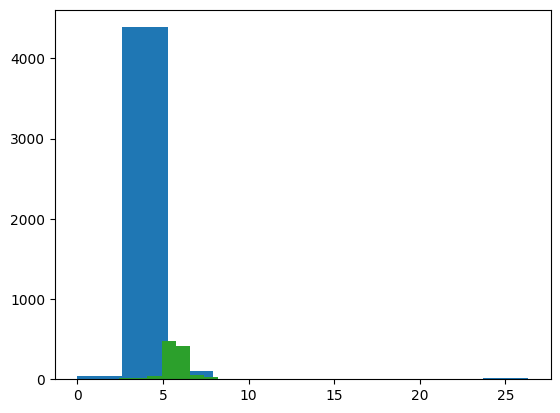

In [84]:
plt.hist(X1[1234])
plt.hist(UX1[1234])
plt.hist(uX1[1234])

In [85]:
def outlier_remove(data, threshold=1.5):
	removed_data = []
	for row in data:
		q1, q3 = np.percentile(row, [25, 75])
		IQR = q3 - q1
		avg = np.mean(row)
		filtered_data = []
		lower_bound = q1 - (threshold * IQR) 
		upper_bound = q3 + (threshold * IQR) 
		
		for t in row:
			if t >= lower_bound and t <= upper_bound: 
				filtered_data.append(t)	
				continue
			filtered_data.append(avg)

		removed_data.append(filtered_data)
	return removed_data


In [86]:
X1_m = outlier_remove(X1)
UX1_m = outlier_remove(UX1)
uX1_m = outlier_remove(uX1)

(array([ 13.,  23.,  22., 376., 165.,  55., 337.,  17.,  10.,  28.]),
 array([4.33 , 4.599, 4.868, 5.137, 5.406, 5.675, 5.944, 6.213, 6.482,
        6.751, 7.02 ]),
 <BarContainer object of 10 artists>)

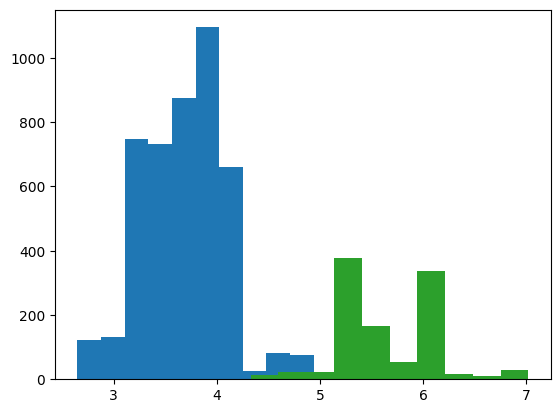

In [87]:
plt.hist(X1_m[1234])
plt.hist(UX1_m[1234])
plt.hist(uX1_m[1234])

---
## 2. Implement candidate features

In [88]:
# Candidate features
 
# Total packets
total_num = []
total_sum_dir = []
total_avg = []

# Incoming packets
inpkt_num = []
inpkt_avg = []
inpkt_sum = []
inpkt_num_frac_total = []
inpkt_avg_ordering = []
inpkt_std_ordering = []
inpkt_num_frac_outpkt = []
inpkt_sum_firstn = []
inpkt_num_firstn = []

# Outgoing packets
outpkt_num = []
outpkt_avg = []
outpkt_sum = []
outpkt_num_frac_total = []
outpkt_avg_ordering = []
outpkt_std_ordering = []
outpkt_num_frac_inpkt = []
outpkt_sum_firstn = []
outpkt_num_firstn = []

# etc
pkt_avg_sec = []
pkt_std_sec = []
pkt_max_sec = []
inpkt_avg_sec = []
inpkt_std_sec = []
inpkt_max_sec = []
outpkt_avg_sec = []
outpkt_std_sec = []
outpkt_max_sec = []

In [89]:
def list_clear():
    # Total packets
    total_num.clear()
    total_sum_dir.clear()
    total_avg.clear()

    # Incoming packets
    inpkt_num.clear()
    inpkt_avg.clear()
    inpkt_sum.clear()
    inpkt_num_frac_total.clear()
    inpkt_avg_ordering.clear()
    inpkt_std_ordering.clear()
    inpkt_num_frac_outpkt.clear()
    inpkt_sum_firstn.clear()
    inpkt_num_firstn.clear()

    # Outgoing packets
    outpkt_num.clear()
    outpkt_avg.clear()
    outpkt_sum.clear()
    outpkt_num_frac_total.clear()
    outpkt_avg_ordering.clear()
    outpkt_std_ordering.clear()
    outpkt_num_frac_inpkt.clear()
    outpkt_sum_firstn.clear()
    outpkt_num_firstn.clear()

    # etc
    pkt_avg_sec.clear()
    pkt_std_sec.clear()
    pkt_max_sec.clear()
    inpkt_avg_sec.clear()
    inpkt_std_sec.clear()
    inpkt_max_sec.clear()
    outpkt_avg_sec.clear()
    outpkt_std_sec.clear()
    outpkt_max_sec.clear()

In [90]:
def Feature(X1, X2):
    for time, dir in zip(X1, X2):
        # Total packets
        f1 = len(time)
        total_num.append(f1)
        f2 = sum(dir)
        total_sum_dir.append(f2)
        f3 = np.mean(time)
        total_avg.append(f3)
        
        # Incoming, Outgoing packets
        inpkt = []
        inpkt_index = []
        outpkt = []
        outpkt_index = []
        for i in range(len(dir)):
            if(dir[i] < 0):
                inpkt.append(time[i])
                inpkt_index.append(i)
                continue
            outpkt.append(time[i])
            outpkt_index.append(i)
                
        f5 = len(inpkt)
        inpkt_num.append(f5)
        f6 = np.mean(inpkt)
        inpkt_avg.append(f6)
        f7 = sum(inpkt)
        inpkt_sum.append(f7)
        f8 = f5 / f1
        inpkt_num_frac_total.append(f8)
        f9 = np.mean(inpkt_index)
        inpkt_avg_ordering.append(f9)
        f10 = np.std(inpkt_index)
        inpkt_std_ordering.append(f10)
        
        f13 = len(outpkt)
        outpkt_num.append(f13)
        f14 = np.mean(outpkt)
        outpkt_avg.append(f14)
        f15 = sum(outpkt)
        outpkt_sum.append(f15)
        f16 = f13 / f1
        outpkt_num_frac_total.append(f16)
        f17 = np.mean(outpkt_index)
        outpkt_avg_ordering.append(f17)
        f18 = np.std(outpkt_index)
        outpkt_std_ordering.append(f18)
        
        f11 = f5 / f13
        inpkt_num_frac_outpkt.append(f11)
        f19 = f13 / f5
        outpkt_num_frac_inpkt.append(f19)
        
        # 임의로 n=30 설정. 추후에 여러 값을 넣어서 실험해보는 게 좋을 것 같다.
        n = 30
        f12 = f21 = f22 = f23 = 0
        for i in range(n):
            if(dir[i] < 0):
                f22 += 1
                f12 += time[i]
                continue
            f23 += 1
            f21 += time[i]
        inpkt_sum_firstn.append(f12)
        outpkt_sum_firstn.append(f21)
        inpkt_num_firstn.append(f22)
        outpkt_num_firstn.append(f23) 

        #etc
        #이부분에서 자꾸 오류가 나서 일단은 주석처리 해뒀어요 어차피 순위권에 안 들어가는 피쳐라 모델 학습에 당장 지장가는 건 없을 거예요
        #나중에 데이터 전처리 좀 더 하고 피쳐 다듬을 때 고칠게요!!
        """
        pkt_num_sec = []
        inpkt_num_sec = []
        outpkt_num_sec = []
        inpkt_set = set(inpkt_index)
        outpkt_set = set(outpkt_index)
        start_t = 0
        while start_t <= time_seq[-1]: 
            end_t = start_t + 1
            start_idx = bisect_left(time, start_t)
            end_idx = bisect_right(time, end_t - 1e-9)

            pkt_count = end_idx - start_idx
            inpkt_count = sum(1 for idx in range(start_idx, end_idx) if idx in inpkt_set)
            outpkt_count = sum(1 for idx in range(start_idx, end_idx) if idx in outpkt_set)

            pkt_num_sec.append(pkt_count)
            inpkt_num_sec.append(inpkt_count)
            outpkt_num_sec.append(outpkt_count)
            
            start_t = end_t

        pkt_avg_sec.append(np.mean(pkt_num_sec))
        pkt_std_sec.append(np.std(pkt_num_sec))
        pkt_max_sec.append(max(pkt_num_sec))
        inpkt_avg_sec.append(np.mean(inpkt_num_sec))
        inpkt_std_sec.append(np.std(inpkt_num_sec))
        inpkt_max_sec.append(max(inpkt_num_sec))
        outpkt_avg_sec.append(np.mean(outpkt_num_sec))
        outpkt_std_sec.append(np.std(outpkt_num_sec))
        outpkt_max_sec.append(max(outpkt_num_sec))
    """



---
## 3. Convert dataframe to cvs file

* mon_standard.pkl > array code > mon_labels.cvs

In [91]:
ydata = { 'label' : y }
ydf = pd.DataFrame(ydata)

In [92]:
ydf.to_csv('mon_labels.csv', index=False)

* mon_standard.pkl > array code > mon_features.cvs

In [93]:
Feature(X1, X2)

In [94]:
data = {
    'total_num': total_num,
    'total_sum_dir': total_sum_dir,
    'total_avg': total_avg,
    'inpkt_num': inpkt_num,
    'inpkt_avg': inpkt_avg,
    'inpkt_sum': inpkt_sum,
    'inpkt_num_frac_total': inpkt_num_frac_total,
    'inpkt_avg_ordering': inpkt_avg_ordering,
    'inpkt_std_ordering': inpkt_std_ordering,
    'inpkt_num_frac_outpkt': inpkt_num_frac_outpkt,
    'inpkt_sum_firstn': inpkt_sum_firstn,
    'outpkt_num': outpkt_num,
    'outpkt_avg': outpkt_avg,
    'outpkt_sum': outpkt_sum,
    'outpkt_num_frac_total': outpkt_num_frac_total,
    'outpkt_avg_ordering': outpkt_avg_ordering,
    'outpkt_std_ordering': outpkt_std_ordering,
    'outpkt_num_frac_inpkt': outpkt_num_frac_inpkt,
    'outpkt_sum_firstn': outpkt_sum_firstn,
    # 'pkt_avg_sec': pkt_avg_sec,
    # 'pkt_std_sec': pkt_std_sec,
    # 'pkt_max_sec': pkt_max_sec,
    # 'inpkt_avg_sec': inpkt_avg_sec,
    # 'inpkt_std_sec': inpkt_std_sec,
    # 'inpkt_max_sec': inpkt_max_sec,
    # 'outpkt_avg_sec': outpkt_avg_sec,
    # 'outpkt_std_sec': outpkt_std_sec,
    # 'outpkt_max_sec': outpkt_max_sec
}
df = pd.DataFrame(data)

In [95]:
print(df.head())

   total_num  total_sum_dir  total_avg  inpkt_num  inpkt_avg  inpkt_sum  \
0       1421        -603648   4.315749       1300   4.292023    5579.63   
1        518        -183296   4.611815        438   4.673242    2046.88   
2       1358        -574464   5.488969       1240   5.459452    6769.72   
3       1446        -615424   5.995512       1324   5.948693    7876.07   
4       1406        -602112   4.698869       1291   4.663873    6021.06   

   inpkt_num_frac_total  inpkt_avg_ordering  inpkt_std_ordering  \
0              0.914849          704.106154          398.486335   
1              0.845560          264.406393          150.591146   
2              0.913108          668.259677          381.878642   
3              0.915629          713.503021          406.205288   
4              0.918208          694.740511          395.028889   

   inpkt_num_frac_outpkt  inpkt_sum_firstn  outpkt_num  outpkt_avg  \
0              10.743802             16.10         121    4.570661   
1     

In [96]:
df.to_csv('mon_features.csv', index=False)

* unmon_standard10.pkl > array code > unmon_features.cvs
  * If you don't have enough computing resources, skip the codes below and start from the unmon_standard10_3000.pkl

In [97]:
list_clear()

In [98]:
Feature(UX1, UX2)

In [99]:
data2 = {
    'total_num': total_num,
    'total_sum_dir': total_sum_dir,
    'total_avg': total_avg,
    'inpkt_num': inpkt_num,
    'inpkt_avg': inpkt_avg,
    'inpkt_sum': inpkt_sum,
    'inpkt_num_frac_total': inpkt_num_frac_total,
    'inpkt_avg_ordering': inpkt_avg_ordering,
    'inpkt_std_ordering': inpkt_std_ordering,
    'inpkt_num_frac_outpkt': inpkt_num_frac_outpkt,
    'inpkt_sum_firstn': inpkt_sum_firstn,
    'outpkt_num': outpkt_num,
    'outpkt_avg': outpkt_avg,
    'outpkt_sum': outpkt_sum,
    'outpkt_num_frac_total': outpkt_num_frac_total,
    'outpkt_avg_ordering': outpkt_avg_ordering,
    'outpkt_std_ordering': outpkt_std_ordering,
    'outpkt_num_frac_inpkt': outpkt_num_frac_inpkt,
    'outpkt_sum_firstn': outpkt_sum_firstn,
    # 'pkt_avg_sec': pkt_avg_sec,
    # 'pkt_std_sec': pkt_std_sec,
    # 'pkt_max_sec': pkt_max_sec,
    # 'inpkt_avg_sec': inpkt_avg_sec,
    # 'inpkt_std_sec': inpkt_std_sec,
    # 'inpkt_max_sec': inpkt_max_sec,
    # 'outpkt_avg_sec': outpkt_avg_sec,
    # 'outpkt_std_sec': outpkt_std_sec,
    # 'outpkt_max_sec': outpkt_max_sec
}
df2 = pd.DataFrame(data2)

In [100]:
df2.to_csv('unmon_features.csv', index=False)

* unmon_standard10.pkl > array code > unmon_features.cvs

In [101]:
list_clear()

In [102]:
Feature(uX1, uX2)

In [103]:
data3 = {
    'total_num': total_num,
    'total_sum_dir': total_sum_dir,
    'total_avg': total_avg,
    'inpkt_num': inpkt_num,
    'inpkt_avg': inpkt_avg,
    'inpkt_sum': inpkt_sum,
    'inpkt_num_frac_total': inpkt_num_frac_total,
    'inpkt_avg_ordering': inpkt_avg_ordering,
    'inpkt_std_ordering': inpkt_std_ordering,
    'inpkt_num_frac_outpkt': inpkt_num_frac_outpkt,
    'inpkt_sum_firstn': inpkt_sum_firstn,
    'outpkt_num': outpkt_num,
    'outpkt_avg': outpkt_avg,
    'outpkt_sum': outpkt_sum,
    'outpkt_num_frac_total': outpkt_num_frac_total,
    'outpkt_avg_ordering': outpkt_avg_ordering,
    'outpkt_std_ordering': outpkt_std_ordering,
    'outpkt_num_frac_inpkt': outpkt_num_frac_inpkt,
    'outpkt_sum_firstn': outpkt_sum_firstn,
    # 'pkt_avg_sec': pkt_avg_sec,
    # 'pkt_std_sec': pkt_std_sec,
    # 'pkt_max_sec': pkt_max_sec,
    # 'inpkt_avg_sec': inpkt_avg_sec,
    # 'inpkt_std_sec': inpkt_std_sec,
    # 'inpkt_max_sec': inpkt_max_sec,
    # 'outpkt_avg_sec': outpkt_avg_sec,
    # 'outpkt_std_sec': outpkt_std_sec,
    # 'outpkt_max_sec': outpkt_max_sec
}
df3 = pd.DataFrame(data3)

In [104]:
df3.to_csv('unmon3000_features.csv', index=False)

---
## 4. RF to get feature importance score

In [105]:

X_normalized = StandardScaler().fit_transform(df.values)
X = pd.DataFrame(X_normalized)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=1
)

In [107]:
clf = RandomForestClassifier(n_estimators=20, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=0)

In [108]:
clf.fit(X_train, y_train)
imp_score=clf.feature_importances_

In [109]:
top_indices=np.argsort(imp_score)[::-1][:5]
print(top_indices)
top_feature_names=[df.columns[int(x)] for x in top_indices]
print(top_feature_names)

[15 16 11  7  0]
['outpkt_avg_ordering', 'outpkt_std_ordering', 'outpkt_num', 'inpkt_avg_ordering', 'total_num']


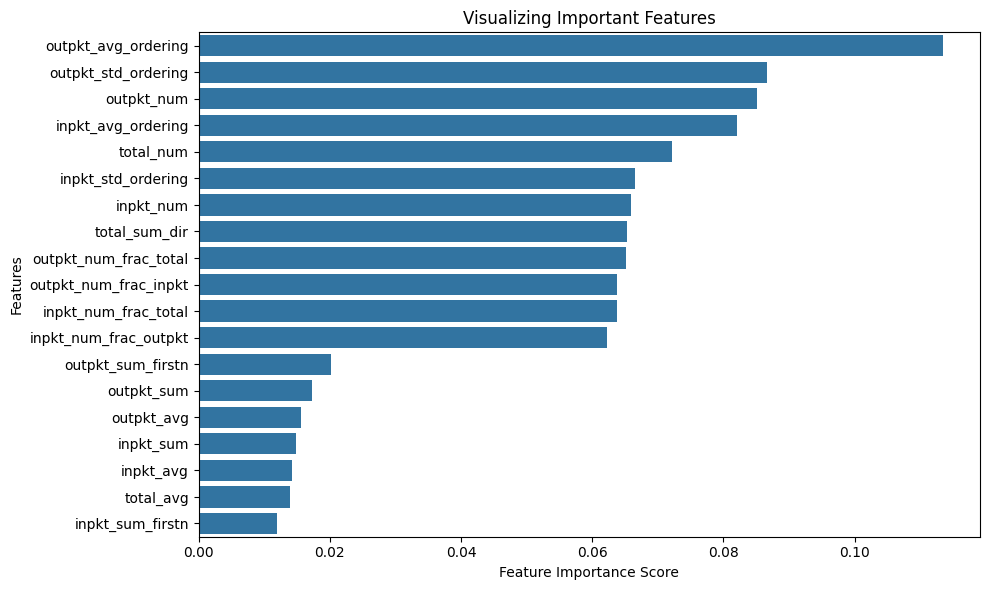

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, index=df.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout() 